In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [4]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [6]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [7]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [8]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [9]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [10]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [11]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

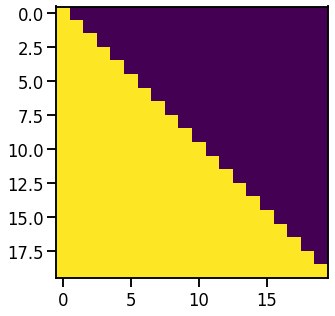

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [13]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [14]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [15]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [16]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [17]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

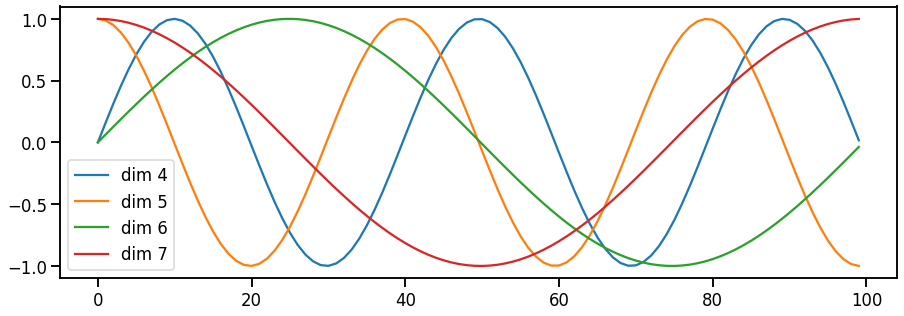

In [18]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [19]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [20]:
tmp_model = make_model(10, 10, 2)
None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [21]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [22]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [23]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [24]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

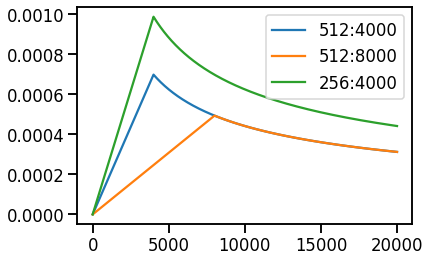

In [25]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [26]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


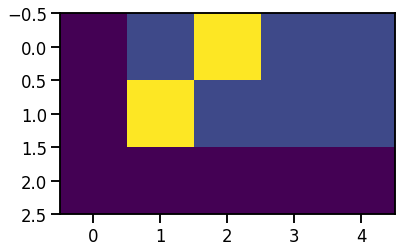

In [77]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

print(crit.true_dist)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


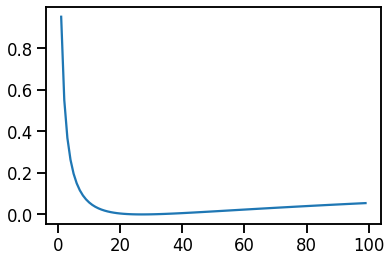

In [28]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1])))
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

In [29]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [1]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss * norm

In [31]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 3.063745 Tokens per Sec: 292.948059
Epoch Step: 1 Loss: 1.996201 Tokens per Sec: 502.633453
tensor(1.9304, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.986158 Tokens per Sec: 422.202301
Epoch Step: 1 Loss: 1.711971 Tokens per Sec: 510.824005
tensor(1.7390, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.868829 Tokens per Sec: 418.845337
Epoch Step: 1 Loss: 1.503874 Tokens per Sec: 514.813416
tensor(1.5215, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.601673 Tokens per Sec: 399.446320
Epoch Step: 1 Loss: 1.355128 Tokens per Sec: 513.483093
tensor(1.2367, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.457359 Tokens per Sec: 416.750397
Epoch Step: 1 Loss: 1.102058 Tokens per Sec: 493.016602
tensor(1.0968, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.236769 Tokens per Sec: 423.572235
Epoch Step: 1 Loss: 0.675578 Tokens per Sec: 499.791626
tensor(0.6491, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 0.815871 Tokens per Sec: 423.912811
Epoch Step: 1 Loss: 0.475477 Tokens pe

In [32]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


Test

Sample

In [119]:
def get_sample_batch():
  np.random.seed(0)
  data = torch.from_numpy(np.random.randint(1, 11, size=(3, 10)))
  data[:, 0] = 1
  src = Variable(data, requires_grad=False)
  tgt = Variable(data, requires_grad=False)
  torch.manual_seed(0)
  batch = Batch(src, tgt)
  return batch

In [120]:
def get_sample_model():
  encoder = get_sample_encoder()
  decoder = get_sample_decoder()
  src_embed = get_sample_embeddings()
  tgt_embed = get_sample_embeddings()
  generator = get_sample_generator()
  torch.manual_seed(0)
  model = EncoderDecoder(encoder,
                         decoder,
                         src_embed,
                         tgt_embed,
                         generator)
  for p in model.parameters():
    if p.dim() > 1:
      torch.manual_seed(0)
      nn.init.xavier_uniform(p)
  return model

In [121]:
def get_sample_embeddings():
  torch.manual_seed(0)
  embed = nn.Sequential(Embeddings(16, 11), PositionalEncoding(16, 0.1))
  return embed

In [122]:
def get_sample_encoder():
  encoder_layer = get_sample_encoder_layer()
  torch.manual_seed(0)
  encoder = Encoder(encoder_layer, 2)
  return encoder

In [123]:
def get_sample_encoder_layer():
  attn = get_sample_multi_headed_attention()
  ff = get_sample_position_wise_feed_forward()
  torch.manual_seed(0)
  encoder_layer = EncoderLayer(16, attn, ff, 0.1)
  return encoder_layer

In [124]:
def get_sample_multi_headed_attention():
  torch.manual_seed(0)
  attn = MultiHeadedAttention(8, 16, 0.1)
  return attn

In [125]:
def get_sample_position_wise_feed_forward():
  torch.manual_seed(0)
  ff = PositionwiseFeedForward(16, 64)
  return ff

In [126]:
def get_sample_decoder():
  decoder_layer = get_sample_decoder_layer()
  torch.manual_seed(0)
  decoder = Decoder(decoder_layer, 2)
  return decoder

In [127]:
def get_sample_decoder_layer():
  self_attn = get_sample_multi_headed_attention()
  src_attn = get_sample_multi_headed_attention()
  ff = get_sample_position_wise_feed_forward()
  torch.manual_seed(0)
  decoder_layer = DecoderLayer(16, self_attn, src_attn, ff, 0.1)
  return decoder_layer

In [128]:
def get_sample_loss_compute(model):
  generator = model.generator
  criterion = get_sample_criterion()
  opt = get_sample_opt(model)
  torch.manual_seed(0)
  loss_compute = SimpleLossCompute(generator, criterion, opt)
  return loss_compute

In [129]:
def get_sample_generator():
  torch.manual_seed(0)
  generator = Generator(16, 11)
  return generator

In [130]:
def get_sample_criterion():
  torch.manual_seed(0)
  criterion = LabelSmoothing(11, 0, 0.0)
  return criterion

In [137]:
def get_sample_opt(model):
  torch.manual_seed(0)
  opt = NoamOpt(16, 1, 400,
                torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  return opt

Debug

In [146]:
sample_batch = get_sample_batch()
print(sample_batch.src)
print(sample_batch.src_mask)
print(sample_batch.trg)
print(sample_batch.trg_y)
print(sample_batch.trg_mask)
print(sample_batch.ntokens)

tensor([[ 1,  1,  4,  4,  8, 10,  4,  6,  3,  5],
        [ 1,  7,  9,  9,  2,  7,  8,  8,  9,  2],
        [ 1, 10,  9, 10,  5,  4,  1,  4,  6,  1]])
tensor([[[True, True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True]]])
tensor([[ 1,  1,  4,  4,  8, 10,  4,  6,  3],
        [ 1,  7,  9,  9,  2,  7,  8,  8,  9],
        [ 1, 10,  9, 10,  5,  4,  1,  4,  6]])
tensor([[ 1,  4,  4,  8, 10,  4,  6,  3,  5],
        [ 7,  9,  9,  2,  7,  8,  8,  9,  2],
        [10,  9, 10,  5,  4,  1,  4,  6,  1]])
tensor([[[ True, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, Fals

In [147]:
sample_model = get_sample_model()
sample_model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): Linear(in_features=16, out_features=16, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=16, out_features=64, bias=True)
          (w_2): Linear(in_features=64, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (

In [148]:
torch.manual_seed(0)
sample_model.train()
torch.manual_seed(0)
sample_out = sample_model.forward(sample_batch.src,
                                  sample_batch.trg,
                                  sample_batch.src_mask,
                                  sample_batch.trg_mask)
sample_out

tensor([[[-0.9021, -0.2189, -1.2323,  0.1369, -0.2197,  2.1363, -0.5244,
           0.5481,  0.3588, -0.2712,  0.4198, -0.4980, -1.6247,  1.1993,
          -0.7651,  1.4572],
         [-0.8053, -0.0681, -1.2003,  0.1137, -0.2672,  1.9559, -0.2791,
           0.6151,  0.1497, -0.3956,  0.5181, -0.3929, -1.9367,  1.0585,
          -0.6798,  1.6140],
         [-0.7670, -0.4627, -1.3415,  0.0993, -0.2415,  2.5314, -0.0676,
           0.6123,  0.0311, -0.6072,  0.0900, -0.0749, -1.0911,  0.6102,
          -0.9576,  1.6368],
         [-0.7053, -0.3605, -1.0967,  0.1522,  0.0504,  2.2616, -0.1378,
           0.3511,  0.1915, -0.0722, -0.1034, -0.5517, -1.9771,  0.8646,
          -0.4896,  1.6228],
         [-1.5196, -1.4527, -0.6552,  0.1150,  0.0443,  2.1762, -0.7803,
           0.8714,  0.3707,  0.7452, -0.3867,  0.1974, -1.2989,  0.2755,
           0.1267,  1.1711],
         [-1.0698, -0.1384, -0.9405, -0.5094,  0.1905,  2.1892, -0.5718,
           0.5799, -0.0324, -0.6644,  0.4224, -0.239

In [149]:
for i, p in enumerate(sample_model.parameters()):
  print(i)
  print(p)
  print(p.grad)

0
Parameter containing:
tensor([[-0.0032,  0.2323, -0.3564, -0.3187, -0.1668,  0.1161, -0.0086,  0.3433,
         -0.0384,  0.1146, -0.1309, -0.0851, -0.4137, -0.2868, -0.1785,  0.0160],
        [ 0.1712,  0.2598, -0.2936, -0.1886,  0.1573,  0.3596, -0.0891,  0.3240,
         -0.0698,  0.0458,  0.3921, -0.4017, -0.2726, -0.1096, -0.1688,  0.3741],
        [-0.2807, -0.1993, -0.3025, -0.4055, -0.2528,  0.3722,  0.1932,  0.2099,
          0.0228, -0.2220,  0.0733, -0.4043, -0.3129, -0.2232,  0.2732,  0.2539],
        [-0.1920, -0.0156,  0.2769,  0.4305,  0.1719,  0.0585,  0.2903, -0.2550,
          0.0807, -0.3357, -0.3001, -0.2237,  0.1959,  0.1741, -0.2565,  0.1308],
        [ 0.2377, -0.0547,  0.0165,  0.1003,  0.2686,  0.4158, -0.3337, -0.1587,
          0.1702,  0.3588,  0.3768,  0.3821,  0.0862, -0.3765,  0.0398, -0.2709],
        [-0.4035,  0.3847,  0.3292, -0.4319,  0.0810, -0.0729, -0.0713, -0.1982,
          0.1665, -0.2565,  0.1587,  0.2190,  0.3100,  0.1619, -0.4286, -0.2809]

In [150]:
sample_loss_compute = get_sample_loss_compute(sample_model)
sample_loss_compute

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [151]:
torch.manual_seed(0)
sample_loss = sample_loss_compute(sample_out,
                                  sample_batch.trg_y,
                                  sample_batch.ntokens)
sample_loss

tensor(93.6374, grad_fn=<MulBackward0>)

In [152]:
for i, p in enumerate(sample_model.parameters()):
  print(i)
  print(p)
  print(p.grad)

0
Parameter containing:
tensor([[-0.0033,  0.2323, -0.3564, -0.3187, -0.1667,  0.1161, -0.0086,  0.3434,
         -0.0385,  0.1146, -0.1308, -0.0851, -0.4137, -0.2868, -0.1785,  0.0160],
        [ 0.1712,  0.2598, -0.2935, -0.1886,  0.1572,  0.3596, -0.0891,  0.3241,
         -0.0698,  0.0459,  0.3921, -0.4017, -0.2726, -0.1097, -0.1688,  0.3742],
        [-0.2807, -0.1993, -0.3025, -0.4055, -0.2528,  0.3722,  0.1932,  0.2099,
          0.0228, -0.2220,  0.0732, -0.4043, -0.3129, -0.2233,  0.2732,  0.2539],
        [-0.1920, -0.0156,  0.2769,  0.4304,  0.1719,  0.0585,  0.2903, -0.2549,
          0.0807, -0.3357, -0.3001, -0.2237,  0.1960,  0.1742, -0.2565,  0.1308],
        [ 0.2377, -0.0547,  0.0166,  0.1003,  0.2686,  0.4158, -0.3337, -0.1587,
          0.1701,  0.3588,  0.3768,  0.3820,  0.0862, -0.3765,  0.0398, -0.2709],
        [-0.4036,  0.3847,  0.3293, -0.4320,  0.0811, -0.0729, -0.0712, -0.1982,
          0.1665, -0.2564,  0.1587,  0.2189,  0.3100,  0.1619, -0.4286, -0.2809]

In [162]:
torch.manual_seed(0)
sample_out = sample_model.forward(sample_batch.src,
                                  sample_batch.trg,
                                  sample_batch.src_mask,
                                  sample_batch.trg_mask)
sample_out

tensor([[[-0.9151, -0.2270, -1.2250,  0.1490, -0.2162,  2.1362, -0.5366,
           0.5331,  0.3651, -0.2601,  0.4227, -0.4911, -1.6194,  1.2083,
          -0.7723,  1.4488],
         [-0.8221, -0.0771, -1.1941,  0.1266, -0.2654,  1.9584, -0.2909,
           0.6024,  0.1584, -0.3857,  0.5220, -0.3871, -1.9315,  1.0665,
          -0.6858,  1.6061],
         [-0.7885, -0.4733, -1.3348,  0.1174, -0.2362,  2.5360, -0.0790,
           0.5986,  0.0414, -0.5899,  0.0917, -0.0683, -1.0888,  0.6174,
          -0.9668,  1.6227],
         [-0.7241, -0.3709, -1.0911,  0.1642,  0.0540,  2.2650, -0.1473,
           0.3362,  0.2018, -0.0603, -0.1002, -0.5453, -1.9718,  0.8711,
          -0.4937,  1.6125],
         [-1.5358, -1.4649, -0.6507,  0.1222,  0.0445,  2.1716, -0.7951,
           0.8512,  0.3785,  0.7662, -0.3797,  0.1998, -1.2775,  0.2842,
           0.1285,  1.1556],
         [-1.0873, -0.1474, -0.9348, -0.4962,  0.1952,  2.1942, -0.5897,
           0.5646, -0.0233, -0.6500,  0.4279, -0.231

In [163]:
torch.manual_seed(0)
sample_loss = sample_loss_compute(sample_out,
                                  sample_batch.trg_y,
                                  sample_batch.ntokens)
sample_loss

tensor(92.8094, grad_fn=<MulBackward0>)

In [164]:
for i, p in enumerate(sample_model.parameters()):
  print(i)
  print(p)
  print(p.grad)

0
Parameter containing:
tensor([[-3.7106e-03,  2.3182e-01, -3.5592e-01, -3.1914e-01, -1.6638e-01,
          1.1658e-01, -9.0481e-03,  3.4380e-01, -3.8897e-02,  1.1505e-01,
         -1.3039e-01, -8.4647e-02, -4.1415e-01, -2.8724e-01, -1.7897e-01,
          1.5623e-02],
        [ 1.7072e-01,  2.5935e-01, -2.9309e-01, -1.8903e-01,  1.5681e-01,
          3.6004e-01, -8.9583e-02,  3.2450e-01, -7.0264e-02,  4.6288e-02,
          3.9255e-01, -4.0122e-01, -2.7307e-01, -1.1009e-01, -1.6926e-01,
          3.7459e-01],
        [-2.8114e-01, -1.9886e-01, -3.0205e-01, -4.0508e-01, -2.5324e-01,
          3.7175e-01,  1.9369e-01,  2.1034e-01,  2.3242e-02, -2.2247e-01,
          7.2789e-02, -4.0383e-01, -3.1335e-01, -2.2370e-01,  2.7274e-01,
          2.5342e-01],
        [-1.9157e-01, -1.5155e-02,  2.7647e-01,  4.3000e-01,  1.7232e-01,
          5.8965e-02,  2.8986e-01, -2.5449e-01,  8.0221e-02, -3.3525e-01,
         -2.9965e-01, -2.2416e-01,  1.9640e-01,  1.7461e-01, -2.5697e-01,
          1.3129e-0